## Importing Essentials Libraries

In [1]:
import os

# Usual Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import os
from sklearn.model_selection import GridSearchCV


# Librosa (the mother of audio files)
import librosa
import librosa.display
import IPython.display as ipd
import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'sklearn'

## Loading Data

In [ ]:

general_path = '/home/aashish/Desktop'
dirs = list(os.listdir(f'{general_path}/archive/train'))
print(dirs)

['uncomfortable', 'hungry', 'sleepy']


In [ ]:
# Numbers of files in each sample
sum=0
for dir in dirs:
    print(f'{dir} ========> {len(os.listdir(f"{general_path}/archive/train/{dir}"))}')
    sum+= len(os.listdir(f"{general_path}/archive/train/{dir}"))
print(f'\n\nthe total numbers of data ======> {sum}')

uncomfortable ========> 160
hungry ========> 160
sleepy ========> 144


the total numbers of data ======> 464


### librosa.load(path, *, sr=22050, mono=True, offset=0.0, duration=None, dtype=<class 'numpy.float32'>, res_type='soxr_hq')
* Load an audio file as a floating point time series.
* Audio will be automatically resampled to the given rate (default sr=22050).


* Returns
* y=np.ndarray [shape=(n,) or (…, n)]    audio time series

* sr=number > 0 [scalar] sampling rate of y



Audio sounds can be thought of as an one-dimensional vector that stores numerical values corresponding to each sample. The time-series plot is a two dimensional plot of those sample values as a function of time.

In [ ]:
# Importing 1 file
y, sr = librosa.load(f'{general_path}/archive/train/hungry/hungry_0.wav')

print('y:', y, '\n')
print('y shape:', np.shape(y), '\n')
print('Sample Rate (Hz):', sr, '\n')

# Verify length of the audio
print(f'Length of Audio: {np.shape(y)[0]/sr}')

y: [-0.00571632  0.00116515  0.01206319 ...  0.04719418  0.00435736
  0.        ] 

y shape: (339201,) 

Sample Rate (Hz): 22050 

Length of Audio: 15.38326530612245


## Trim leading and trailing silence from an audio signal (silence before and after the actual audio)

### librosa.effects.trim(y, *, top_db=60, ref=<function amax>, frame_length=2048, hop_length=512, aggregate=<function amax>)
    ref:number or callable
The reference amplitude. By default, it uses np.max and compares to the peak amplitude in the signal.
    
    frame_lengtha:int > 0
The number of samples per analysis frame
    
    hop_length:int > 0
The number of samples between analysis frames
    
    
    Returns:
y_trimmed= numpy ndarrya =np.ndarray, shape=(…, m)
The trimmed signal
    
    index=np.ndarray, shape=(2,)
the interval of y corresponding to the non-silent region
    : y_trimmed = y[index[0]:index[1]] (for mono) or y_trimmed = y[:, index[0]:index[1]] (for stereo).

In [ ]:

audio_file, index = librosa.effects.trim(y)

# the result is an numpy ndarray
print('Audio File:', audio_file, '\n')
print('Audio File shape:', np.shape(audio_file))
print(index[1])

Audio File: [-0.00571632  0.00116515  0.01206319 ...  0.04719418  0.00435736
  0.        ] 

Audio File shape: (339201,)
339201


## Visualize a waveform in the time domain

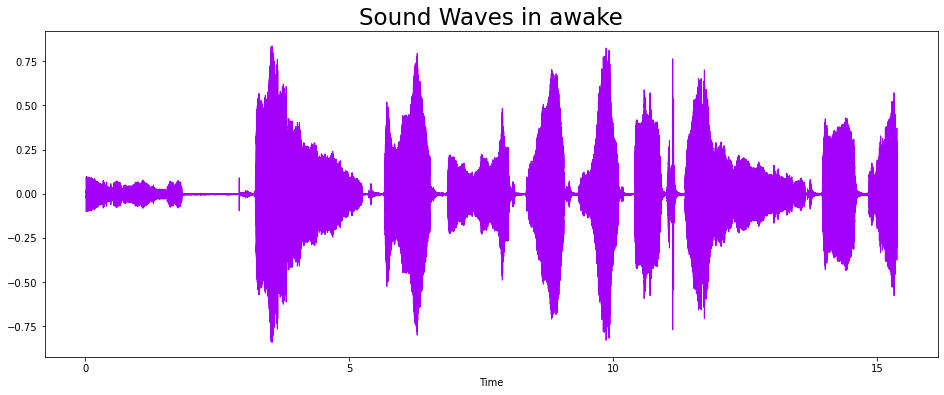

In [ ]:

plt.figure(figsize = (16, 6))
librosa.display.waveshow(y = audio_file, sr = sr, color = "#A300F9");
plt.title("Sound Waves in awake", fontsize = 23);

## Short-Time Fourier Transform (STFT)
STFT provides the time-localized frequency information for situations in which frequency components of a signal vary over time, whereas the standard Fourier transform provides the frequency information averaged over the entire signal time interval.

The STFT represents a signal in the time-frequency domain by computing discrete Fourier transforms (DFT) over short overlapping windows.


### librosa.stft(y, *, n_fft=2048, hop_length=None, win_length=None, window='hann', center=True, dtype=None, pad_mode='constant', out=None)
y= input signal np.ndarray
Returns:
  D:np.ndarray [shape=(…, 1 + n_fft/2, n_frames), dtype=dtype]
      Complex-valued matrix of short-term Fourier transform coefficients.

  If a pre-allocated out array is provided, then D will be a reference to out.

  If out is larger than necessary, then D will be a sliced view: D = out[…, :n_frames ]
  
    np.abs(D[..., f, t]) is the magnitude of frequency bin f at frame t, and

    np.angle(D[..., f, t]) is the phase of frequency bin f at frame t

In [ ]:
# Default FFT window size
n_fft = 2048 # FFT window size
hop_length = 512 # number audio of frames between STFT columns (looks like a good default)

# Short-time Fourier transform (STFT)
# return the magnitude of frequency bin f at frame t
D = np.abs(librosa.stft(audio_file, n_fft = n_fft, hop_length = hop_length))

print('Shape of D object:', np.shape(D))

Shape of D object: (1025, 663)


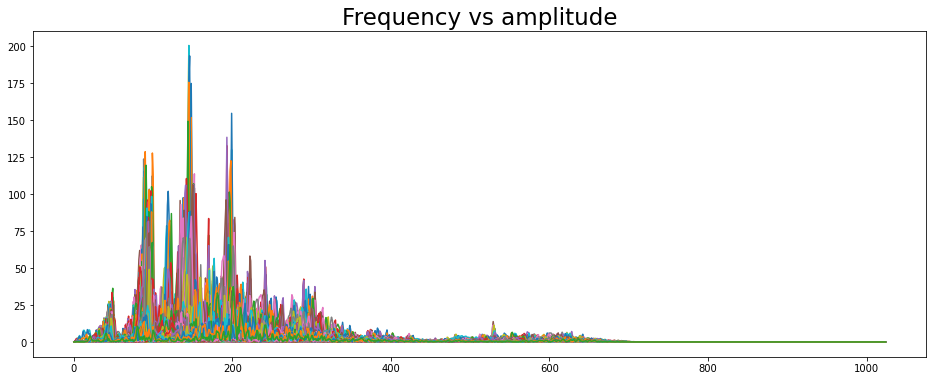

In [ ]:
plt.figure(figsize = (16, 6))
plt.plot(D);
plt.title("Frequency vs amplitude", fontsize = 23);

## Spectrogram

* A spectrogram is a visual representation of the spectrum of frequencies of a signal as it varies with time.

* A spectrogram is a visual way of representing the signal strength, or “loudness”, of a signal over time at various frequencies present in a particular waveform. Not only can one see whether there is more or less energy at, for example, 2 Hz vs 10 Hz, but one can also see how energy levels vary over time.

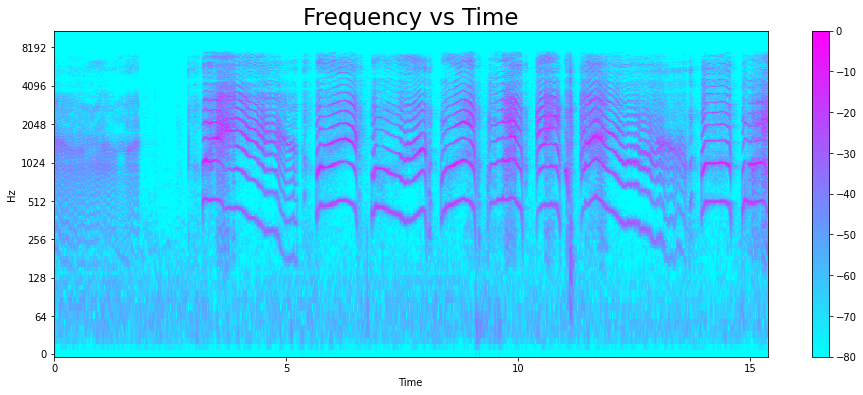

In [ ]:
# Convert an amplitude spectrogram to Decibels-scaled spectrogram.
DB = librosa.amplitude_to_db(D, ref = np.max)
# Creating the Spectogram
plt.figure(figsize = (16, 6))
#Display a s pectrogram
librosa.display.specshow(DB, sr = sr, hop_length = hop_length, x_axis = 'time', y_axis = 'log',
                       cmap = 'cool')
plt.title("Frequency vs Time", fontsize = 23);
plt.colorbar();

### Mel Spectrogram

* The mel scale (after the word melody) is a perceptual scale of pitches judged by listeners to be equal in distance from one another. The reference point between this scale and normal frequency measurement is defined by assigning a perceptual pitch of 1000 mels to a 1000 Hz tone, 40 dB above the listener's threshold. Above about 500 Hz, increasingly large intervals are judged by listeners to produce equal pitch increments.

A formula to convert f hertz into m mels is:

$$m=2595\log_{10}\left(1+\frac{f}{700}\right)$$

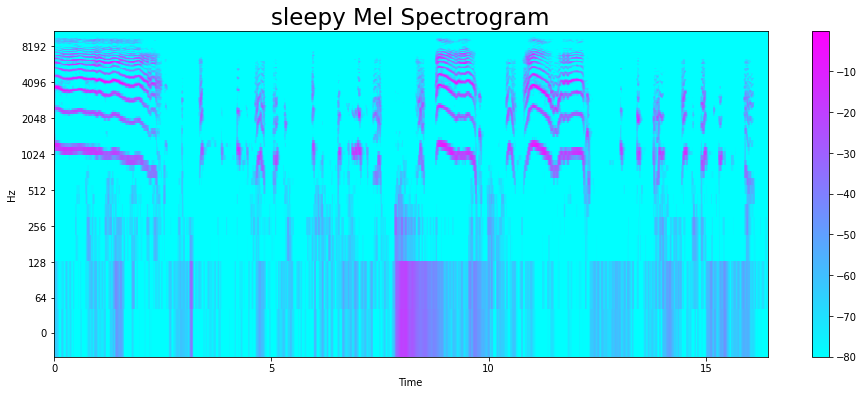

In [ ]:
y, sr = librosa.load(f'{general_path}/archive/train/sleepy/sleepy_0.wav')
y, _ = librosa.effects.trim(y)


S = librosa.feature.melspectrogram(y, sr=sr)
S_DB = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize = (16, 6))
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis = 'time', y_axis = 'log',
                        cmap = 'cool');
plt.colorbar();
plt.title("sleepy Mel Spectrogram", fontsize = 23);

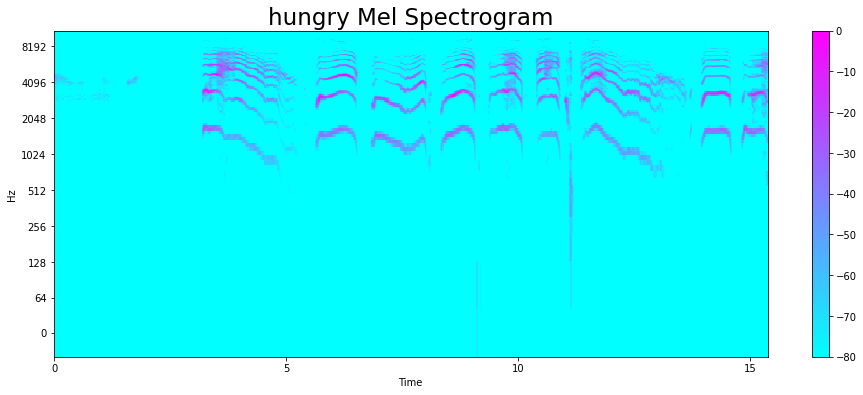

In [ ]:
y, sr = librosa.load(f'{general_path}/archive/train/hungry/hungry_0.wav')
y, _ = librosa.effects.trim(y)


S = librosa.feature.melspectrogram(y, sr=sr)
S_DB = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize = (16, 6))
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis = 'time', y_axis = 'log',
                        cmap = 'cool');
plt.colorbar();
plt.title("hungry Mel Spectrogram", fontsize = 23);

## Audio Features

### Zero Crossing Rate¶
* the rate at which the signal changes from positive to negative or back.

In [ ]:
# Compute the zero-crossing rate of an audio signal
zero_crossing = librosa.zero_crossings(audio_file, pad=False)

# Reset the sum function to its default value
sum = __builtins__.sum

# Compute the total number of zero crossings
total_zero_crossings = sum(zero_crossing)
print("Number of zero crossings:", total_zero_crossings)


Number of zero crossings: 47355


## Harmonics and Perceptrual
* Harmonics are characteristichs that human ears can't distinguish (represents the sound color)
* Perceptrual understanding shock wave represents the sound rhythm and emotion


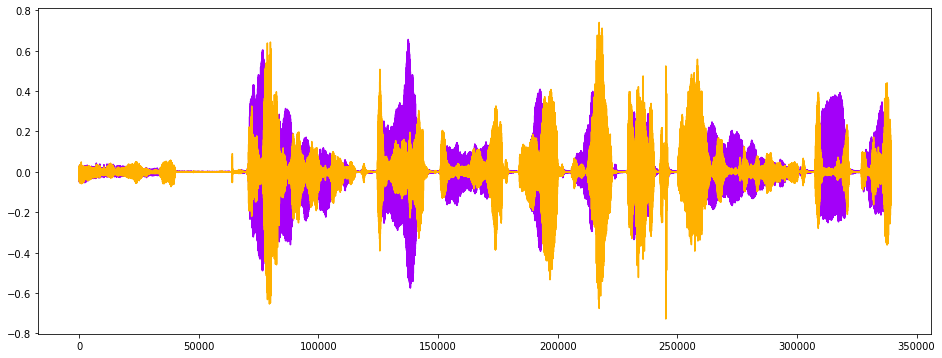

In [ ]:
y_harm, y_perc = librosa.effects.hpss(audio_file)

plt.figure(figsize = (16, 6))
plt.plot(y_harm, color = '#A300F9');
plt.plot(y_perc, color = '#FFB100');

## Tempo BMP (beats per minute)
Dynamic programming beat tracker.



In [ ]:
tempo, _ = librosa.beat.beat_track(audio_file, sr = sr)
tempo

198.76802884615384

## Spectral Centroid
* indicates where the ”centre of mass” for a sound is located and is calculated as the weighted mean of the frequencies present in the sound.

In [ ]:
# Calculate the Spectral Centroids
spectral_centroids = librosa.feature.spectral_centroid(audio_file, sr=sr)[0]

# Shape is a vector
print('Centroids:', spectral_centroids, '\n')
print('Shape of Spectral Centroids:', spectral_centroids.shape, '\n')

# Computing the time variable for visualization
frames = range(len(spectral_centroids))

# Converts frame counts to time (seconds)
t = librosa.frames_to_time(frames)

print('frames:', frames, '\n')
print('t:', t)

# Function that normalizes the Sound Data
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

Centroids: [1736.99814909 1729.25080366 1771.37690794 1700.4434255  1682.37121939
 1657.34311895 1610.46800799 1619.86558356 1630.83494282 1612.27884876
 1617.14241633 1613.01039725 1572.89915943 1603.53441337 1725.50510003
 1679.52884088 1646.74499633 1709.74104086 1604.39088878 1581.51073662
 1686.31730422 1642.98948852 1615.49812894 1696.92741955 1635.59930615
 1597.48143575 1602.11648211 1645.57845206 1709.01393551 1677.04187618
 1670.5450918  1755.43882356 1793.16735693 1797.22207983 1847.33723572
 1882.23062229 1894.27174485 1914.00397079 1973.48840138 1989.50770396
 2061.4950588  2018.37400949 2065.40539819 1932.73120032 1899.68045964
 1795.09321778 1693.03548813 1705.27644549 1654.45905084 1727.93355834
 1622.16146963 1504.43383787 1510.54558564 1599.28099107 1616.27436019
 1584.1293418  1554.343063   1738.32221819 1803.69320518 1714.97681197
 1888.76783728 2202.17447469 2293.97741344 2260.71439484 2086.83694243
 2084.49493515 2200.63841845 2178.36301743 1999.35123523 1922.4975

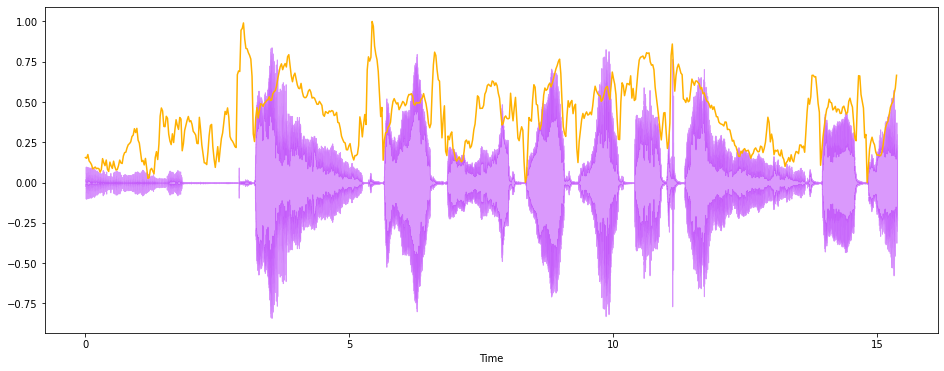

In [ ]:
#Plotting the Spectral Centroid along the waveform
plt.figure(figsize = (16, 6))
librosa.display.waveshow(audio_file, sr=sr, alpha=0.4, color = '#A300F9');
plt.plot(t, normalize(spectral_centroids), color='#FFB100');

## Spectral Rolloff
* is a measure of the shape of the signal. It represents the frequency below which a specified percentage of the total spectral energy, e.g. 85%, lies

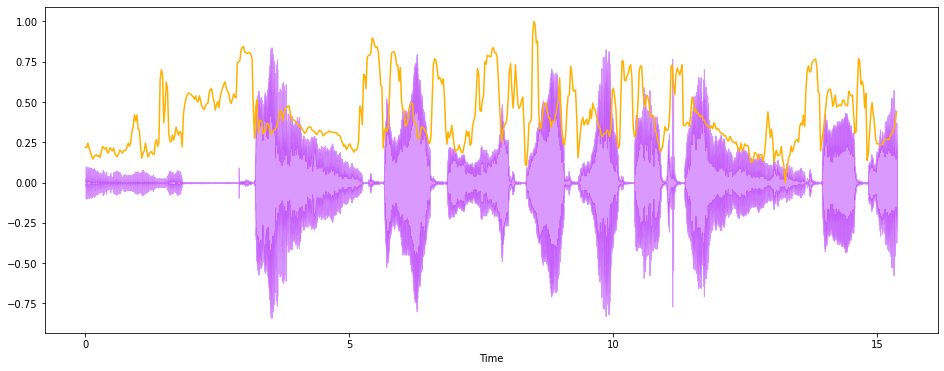

In [ ]:
# Spectral RollOff Vector
spectral_rolloff = librosa.feature.spectral_rolloff(audio_file, sr=sr)[0]

# The plot
plt.figure(figsize = (16, 6))
librosa.display.waveshow(audio_file, sr=sr, alpha=0.4, color = '#A300F9');
plt.plot(t, normalize(spectral_rolloff), color='#FFB100');

## Mel-Frequency Cepstral Coefficients:
* The Mel frequency cepstral coefficients (MFCCs) of a signal are a small set of features (usually about 10–20) which concisely describe the overall shape of a spectral envelope. It models the characteristics of the human voice.

mfccs shape: (20, 663)
[[-295.15317   -263.55618   -257.0968    ...  -97.07766   -108.58227
  -137.6703   ]
 [ 125.74901    128.20464    125.95549   ...   86.73576     82.185074
    69.41077  ]
 [ -88.40903    -98.43808    -98.28972   ... -141.18196   -133.50742
  -123.18167  ]
 ...
 [  -5.117009    -5.8635416   -6.8389163 ...  -17.718103   -15.818546
   -14.063601 ]
 [  -0.4119779   -4.4770527   -9.02359   ...   -1.8486017   -2.137905
    -3.516571 ]
 [   2.5277705    4.2144375    5.4076357 ...    6.0515933    6.0379577
     6.2456684]]


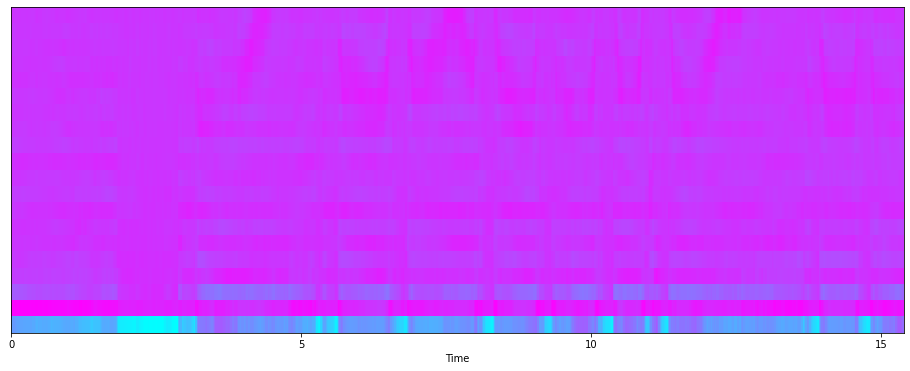

In [ ]:
mfccs = librosa.feature.mfcc(audio_file, sr=sr)
print('mfccs shape:', mfccs.shape)
print(mfccs)

#Displaying  the MFCCs:
plt.figure(figsize = (16, 6))
librosa.display.specshow(mfccs, sr=sr, x_axis='time', cmap = 'cool');

## Perform Feature Scaling
### Data needs to be scaled:
scaling: transforming your data so that it fits within a specific scale, like 0-100 or 0-1. You want to scale data when you're using methods based on measures of how far apart data points, like support vector machines, or SVM or k-nearest neighbors, or KNN

 #### sklearn.preprocessing.scale()
 * Standardize a dataset along any axis . preprocessing.scale() method is helpful in standardization of data points. It would divide by the standard deviation and substract the mean for each data point.

Mean: -1.7261074e-09 

Var: 1.0000001


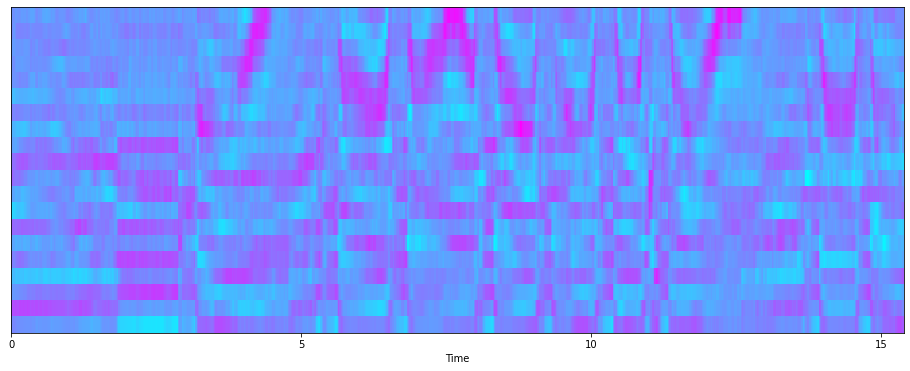

In [ ]:
mfccs = sklearn.preprocessing.scale(mfccs, axis=1)
print('Mean:', mfccs.mean(), '\n')
print('Var:', mfccs.var())

plt.figure(figsize = (16, 6))
librosa.display.specshow(mfccs, sr=sr, x_axis='time', cmap = 'cool');

## Chroma Frequencies
* Chroma features are an interesting and powerful representation for music audio in which the entire spectrum is projected onto 12 bins representing the 12 distinct semitones (or chroma) of the musical octave.

Chromogram shape: (12, 68)


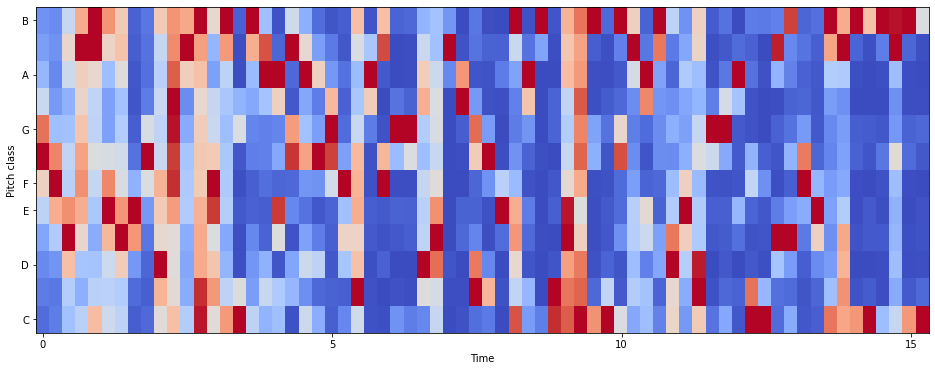

In [ ]:
# Increase or decrease hop_length to change how granular you want your data to be
hop_length = 5000

# Chromogram
chromagram = librosa.feature.chroma_stft(audio_file, sr=sr, hop_length=hop_length)
print('Chromogram shape:', chromagram.shape)

plt.figure(figsize=(16, 6))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm');

In [ ]:
import pandas as pd
data = pd.read_csv('/home/aashish/Downloads/data_splitted.csv')


data = pd.DataFrame(data)

header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()
data.columns = header



1. Normalization
2. PCA
3. The Scatter Plot


### preprocessing.MinMaxScaler()
* Transform features by scaling each feature to a given range. This estimator scales and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one.
* The transformation is given by:
\
X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
\
X_scaled = X_std * (max - min) + min
\
where min, max =feature_range:tuple (min, max), default=(0, 1) (Desired range of transformed data).
\

* fit_transform(X, y=None, **fit_params)
\
 Fit to data, then transform it.


 ### Principal component analysis:

 * Principal component analysis, or PCA, is a dimensionality-reduction method that is often used to reduce the dimensionality of large data sets, by transforming a large set of variables into a smaller one that still contains most of the information in the large set.
 * Reducing the number of variables of a data set naturally comes at the expense of accuracy, but the trick in dimensionality reduction is to trade a little accuracy for simplicity. Because smaller data sets are easier to explore and visualize and make analyzing data much easier and faster for machine learning algorithms without extraneous variables to process.
* the idea of PCA is simple — reduce the number of variables of a data set, while preserving as much information as possible.


In [ ]:
from sklearn import preprocessing

data = data.iloc[:, 1:]
y = data['label']
X = data.loc[:, data.columns != 'label']

#### NORMALIZE X ####
cols = X.columns
# print(cols)
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)


### PCA  COMPONENTS ####
#from sklearn.decomposition import PCA

#pca = PCA(n_components=6)
#principalComponents = pca.fit_transform(X)
#principalDf = pd.DataFrame(data =  principalComponents, columns = ['1','2','3','4','5','6'])

#concatenate with target label
finalDf= pd.concat([X, y], axis = 1)

#pca.explained_variance_ratio_

# 44.93 variance explained

In [ ]:
finalDf

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,0.284547,0.305797,0.397086,0.430563,0.421296,0.418483,0.750766,0.426444,0.141014,0.536676,...,0.360925,0.531984,0.453537,0.519428,0.558245,0.479293,0.340904,0.330562,0.390478,hungry
1,0.181082,0.356027,0.374560,0.468925,0.435715,0.326056,0.726869,0.408548,0.201701,0.517951,...,0.429933,0.542802,0.477582,0.674679,0.605001,0.536479,0.435828,0.375181,0.502740,hungry
2,0.326504,0.312598,0.407120,0.428912,0.420866,0.426864,0.781408,0.477504,0.113556,0.593122,...,0.394108,0.532330,0.499472,0.619906,0.505727,0.451475,0.282855,0.337795,0.424508,hungry
3,0.180472,0.197375,0.328620,0.418246,0.372026,0.302214,0.713126,0.528824,0.165067,0.457182,...,0.454925,0.491459,0.507498,0.547796,0.532523,0.378987,0.323138,0.357520,0.489197,hungry
4,0.116433,0.414862,0.346958,0.378502,0.332465,0.305415,0.863359,0.620761,0.068027,0.586270,...,0.399537,0.548848,0.539891,0.687932,0.373671,0.356102,0.074124,0.311028,0.524444,hungry
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2890,0.239763,0.371723,0.323215,0.461464,0.416247,0.275131,0.788270,0.601458,0.253838,0.415720,...,0.695357,0.438593,0.493536,0.460256,0.410197,0.507551,0.425848,0.611818,0.525489,uncomfortable
2891,0.104546,0.608060,0.284364,0.367837,0.275084,0.272768,0.789995,0.527339,0.180341,0.346109,...,0.670658,0.432907,0.483370,0.366573,0.336329,0.525809,0.539206,0.741710,0.663664,uncomfortable
2892,0.155989,0.427337,0.275312,0.405793,0.323063,0.242444,0.773940,0.580908,0.306089,0.357278,...,0.633144,0.465421,0.516507,0.367589,0.398918,0.350765,0.335845,0.466042,0.560237,uncomfortable
2893,0.153754,0.394974,0.283801,0.414656,0.345901,0.252835,0.779614,0.591910,0.285447,0.430576,...,0.632699,0.477632,0.490485,0.400965,0.340985,0.356243,0.402073,0.551989,0.639766,uncomfortable


## Machine Learning Classification

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve,auc,f1_score,precision_score,recall_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE

In [ ]:

finalDf.head()

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,0.284547,0.305797,0.397086,0.430563,0.421296,0.418483,0.750766,0.426444,0.141014,0.536676,...,0.360925,0.531984,0.453537,0.519428,0.558245,0.479293,0.340904,0.330562,0.390478,hungry
1,0.181082,0.356027,0.374560,0.468925,0.435715,0.326056,0.726869,0.408548,0.201701,0.517951,...,0.429933,0.542802,0.477582,0.674679,0.605001,0.536479,0.435828,0.375181,0.502740,hungry
2,0.326504,0.312598,0.407120,0.428912,0.420866,0.426864,0.781408,0.477504,0.113556,0.593122,...,0.394108,0.532330,0.499472,0.619906,0.505727,0.451475,0.282855,0.337795,0.424508,hungry
3,0.180472,0.197375,0.328620,0.418246,0.372026,0.302214,0.713126,0.528824,0.165067,0.457182,...,0.454925,0.491459,0.507498,0.547796,0.532523,0.378987,0.323138,0.357520,0.489197,hungry
4,0.116433,0.414862,0.346958,0.378502,0.332465,0.305415,0.863359,0.620761,0.068027,0.586270,...,0.399537,0.548848,0.539891,0.687932,0.373671,0.356102,0.074124,0.311028,0.524444,hungry


#### Features and Target variable
* creates the target and feature variables
* normalizes the data


In [ ]:
y = finalDf['label'] # genre variable.
X = finalDf.iloc[:,:-1] #select all columns but not the labels


X

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
0,0.284547,0.305797,0.397086,0.430563,0.421296,0.418483,0.750766,0.426444,0.141014,0.536676,...,0.647124,0.360925,0.531984,0.453537,0.519428,0.558245,0.479293,0.340904,0.330562,0.390478
1,0.181082,0.356027,0.374560,0.468925,0.435715,0.326056,0.726869,0.408548,0.201701,0.517951,...,0.633068,0.429933,0.542802,0.477582,0.674679,0.605001,0.536479,0.435828,0.375181,0.502740
2,0.326504,0.312598,0.407120,0.428912,0.420866,0.426864,0.781408,0.477504,0.113556,0.593122,...,0.564916,0.394108,0.532330,0.499472,0.619906,0.505727,0.451475,0.282855,0.337795,0.424508
3,0.180472,0.197375,0.328620,0.418246,0.372026,0.302214,0.713126,0.528824,0.165067,0.457182,...,0.593095,0.454925,0.491459,0.507498,0.547796,0.532523,0.378987,0.323138,0.357520,0.489197
4,0.116433,0.414862,0.346958,0.378502,0.332465,0.305415,0.863359,0.620761,0.068027,0.586270,...,0.384037,0.399537,0.548848,0.539891,0.687932,0.373671,0.356102,0.074124,0.311028,0.524444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2890,0.239763,0.371723,0.323215,0.461464,0.416247,0.275131,0.788270,0.601458,0.253838,0.415720,...,0.568875,0.695357,0.438593,0.493536,0.460256,0.410197,0.507551,0.425848,0.611818,0.525489
2891,0.104546,0.608060,0.284364,0.367837,0.275084,0.272768,0.789995,0.527339,0.180341,0.346109,...,0.562834,0.670658,0.432907,0.483370,0.366573,0.336329,0.525809,0.539206,0.741710,0.663664
2892,0.155989,0.427337,0.275312,0.405793,0.323063,0.242444,0.773940,0.580908,0.306089,0.357278,...,0.591181,0.633144,0.465421,0.516507,0.367589,0.398918,0.350765,0.335845,0.466042,0.560237
2893,0.153754,0.394974,0.283801,0.414656,0.345901,0.252835,0.779614,0.591910,0.285447,0.430576,...,0.569093,0.632699,0.477632,0.490485,0.400965,0.340985,0.356243,0.402073,0.551989,0.639766


### Splitting the data into training and testing
* 80% - 20% split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Creating a Predefined function to assess the accuracy of a model
* input is the model
* fits the model on the training dataset
* predicts on the testing features
* compares the predictions with the actuals

$$accuracy\_score=\left(\frac{Number\ of\ correct\ prediction}{Total\ number\ of\ correct\ prediction}\right)$$
$$recall\_score=\left(\frac{True\ positive}{True\ positive\ +\ False\ Negative}\right)$$
$$precision\_score=\left(\frac{True\ positive}{True\ positive\ +\ False\ positive}\right)$$
$$F1\_score=\left(\frac{2\ precision * recall}{precision\ +\ Recall}\right)$$

In [ ]:
def model_assess(model, title = "Default"):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(f'{title}')
    print('confusion matrix\n',confusion_matrix(y_test, preds))
    print('precision_score==>',precision_score(y_test,preds,average='macro'))
    print('recall_score==>',recall_score(y_test,preds,average='macro'))
    print('f1_score==>',f1_score(y_test,preds,average='macro'))
    print('Accuracy', title, ':', round(accuracy_score(y_test, preds), 5), '\n')

In [ ]:


# Random Forest
rforest = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=42)
model_assess(rforest, "Random Forest")




Random Forest
confusion matrix
 [[168  32   8]
 [ 41 128  15]
 [ 18  22 147]]
precision_score==> 0.7693635637921723
recall_score==> 0.7631469127632812
f1_score==> 0.765132252260241
Accuracy Random Forest : 0.76511 



In [ ]:

 # support vector machine

svm = SVC(decision_function_shape="ovr",gamma=10 ,C=100, kernel='rbf')
model_assess(svm, "Support Vector Machine")


Support Vector Machine
confusion matrix
 [[180  15  13]
 [ 24 149  11]
 [ 13  12 162]]
precision_score==> 0.8490172461946656
recall_score==> 0.8471591281693583
f1_score==> 0.8478231030273294
Accuracy Support Vector Machine : 0.84801 



In [ ]:
# Neural Nets
nn = MLPClassifier(solver='lbfgs',learning_rate_init=0.01, alpha=0.01, hidden_layer_sizes=(20,20,20), random_state=42,learning_rate='constant', shuffle=False ,validation_fraction=0 )
model_assess(nn, "Neural Nets")

Neural Nets
confusion matrix
 [[150  52   6]
 [ 41 130  13]
 [ 24  26 137]]
precision_score==> 0.7336265156032598
recall_score==> 0.7200986353799653
f1_score==> 0.7237729945068199
Accuracy Neural Nets : 0.72021 

